In [1]:
# using Revise
# path_to_package = "/home/manuel/.julia/dev/PauliPropagation"
# insert!(LOAD_PATH, 1, path_to_package);

using Pkg
Pkg.add(url="https://github.com/MSRudolph/PauliPropagation.jl.git", rev="dev")

    Updating git-repo `https://github.com/MSRudolph/PauliPropagation.jl.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [173]:
using PauliPropagation

In [81]:
θ = 0.1im

0.0 + 0.1im

In [197]:
# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), -pi)
rxmat = tomatrix(PauliRotation(:X, 1), -pi)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

In [100]:
nq = 2
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
# append!(circuit, TransferMapGate([ii], rzmap) for ii in 1:nq);
# append!(circuit, TransferMapGate(collect(pair), rzzmap) for pair in topology);

In [103]:
pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)

PauliSum(nqubits: 2, 1 Pauli term: 
 1.0 * II
)

In [105]:
# Manuel version

nls = 10
overlapsManuel = Float64[overlapwithplus(psum) / sqrt(2^nq)]
for _ in 1:nls
    psum = propagate!(circuit, psum)
    @show psum
    # @show norm(psum)
    mult!(psum, 1/norm(psum))
    push!(overlapsManuel, overlapwithplus(psum) / sqrt(2^nq))
end

psum = PauliSum(nqubits: 2, 4 Pauli terms:
 1.0201 * II
 0.20134 * IX
 0.039739 * XX
 0.20134 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 1.0108 * II
 0.29445 * IX
 0.085778 * XX
 0.29445 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.98587 * II
 0.37458 * IX
 0.14232 * XX
 0.37458 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.95073 * II
 0.43935 * IX
 0.20303 * XX
 0.43935 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.91073 * II
 0.48911 * IX
 0.26267 * XX
 0.48911 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.8701 * II
 0.52586 * IX
 0.31781 * XX
 0.52586 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.83162 * II
 0.55223 * IX
 0.3667 * XX
 0.55223 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.79681 * II
 0.57075 * IX
 0.40883 * XX
 0.57075 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.76625 * II
 0.58357 * IX
 0.44444 * XX
 0.58357 * XI
)
psum = PauliSum(nqubits: 2, 4 Pauli terms:
 0.73998 * II
 0.59235 * IX
 0.47418 * XX
 0.59235

In [90]:
# Zoe Version

nls = 100

pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)

overlapsZoe = Float64[overlapwithplus(psum)]

for _ in 1:nls
    psum = propagate!(circuit, psum)
    #psum
    psumnew = mult!(psum, 1/((2^nq)*getcoeff(psum, :I, 1)))
    push!(overlapsZoe, overlapwithplus(psumnew))
end
psum

PauliSum(nqubits: 8, 256 Pauli terms:
 0.0039062 * IIXIXIIX
 0.0039062 * IXIIIXII
 0.0039062 * IIXXIIIX
 0.0039062 * IIXIXXII
 0.0039062 * XIXIXXIX
 0.0039062 * IXIXIIXX
 0.0039062 * IIIXIXXI
 0.0039062 * IIIIXXXI
 0.0039062 * IIXXXXIX
 0.0039062 * IXIIIIXX
 0.0039062 * IXXXXXIX
 0.0039062 * XXIXXIXX
 0.0039062 * IIIXXIXI
 0.0039062 * IXIXIXII
 0.0039062 * XXIXIIXX
 0.0039062 * IIIIIIXI
 0.0039062 * IXIXIIII
 0.0039062 * XIXIXXII
 0.0039062 * IIXXIXXI
 0.0039062 * XXIIXXII
  ⋮)

In [46]:
using Plots

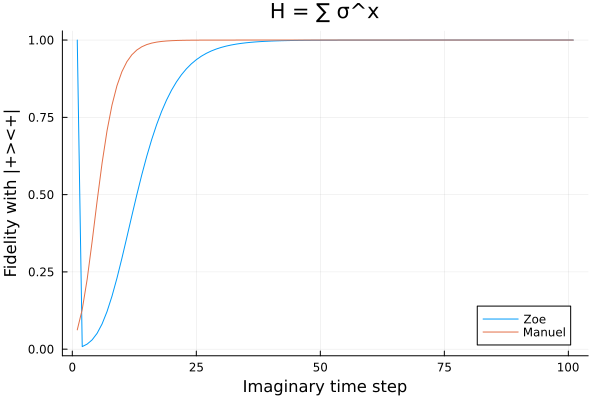

In [91]:
plot(overlapsZoe, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="Zoe", title="H = ∑ σ^x")
plot!(overlapsManuel, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="Manuel", title="H = ∑ σ^x")


In [117]:
pauli_basis_vec = getpaulibasis(1)

4-element Vector{Matrix{ComplexF64}}:
 [0.7071067811865475 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.7071067811865475 + 0.0im]
 [0.0 + 0.0im 0.7071067811865475 + 0.0im; 0.7071067811865475 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im 0.0 - 0.7071067811865475im; 0.0 + 0.7071067811865475im 0.0 + 0.0im]
 [0.7071067811865475 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.7071067811865475 + 0.0im]

In [204]:
using LinearAlgebra

In [230]:
function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

ZMatrix (generic function with 1 method)

In [355]:
function imaginaryTimeEvolution(nqubits::Int, h::Matrix, beta::Float64)
    operator = exp(-beta/2*h)*I(2^nqubits)*exp(-beta/2*h)/(2^nqubits)
    return operator/(2^nqubits*tr(exp(-beta*h)))
end

function imaginaryTimeEvolution2(nqubits::Int, h::Matrix, beta::Float64)
    operator = exp(-beta/2*h)*I(2^nqubits)*exp(-beta/2*h)/(2^nqubits)
    return operator/tr(exp(-beta*h))*(2^nqubits)
end

function imaginaryTimeEvolutionState(nqubits::Int, h::Matrix, beta::Float64, state::vector)
    operator = exp(-beta*h)*state
    return operator/LinearAlgebra.norm(operator)
end

imaginaryTimeEvolutionState (generic function with 1 method)

In [360]:
H = XMatrix(3, 1)+XMatrix(3, 2)+XMatrix(3, 3) - ZMatrix(3, 1)  - ZMatrix(3, 2)*ZMatrix(3, 3)
println(eigen(H).values)
groundState = eigen(H).vectors[:,1]
initialState = ones(2^3)/(sqrt(2^3))
println(initialState'*groundState)
imag = imaginaryTimeEvolutionState(nq, H, 100.0)
println(imag'*groundState)

density = groundState*groundState'


[-3.650281539872879, -2.4142135623730954, -0.8218544151266998, -0.4142135623730936, 0.4142135623730927, 0.8218544151266953, 2.4142135623730963, 3.6502815398728847]
0.08792263623096745
1.0


8×8 Matrix{Float64}:
  0.308819   -0.19086    -0.19086    …   0.0790569   0.0790569  -0.127917
 -0.19086     0.117958    0.117958      -0.0488599  -0.0488599   0.0790569
 -0.19086     0.117958    0.117958      -0.0488599  -0.0488599   0.0790569
  0.308819   -0.19086    -0.19086        0.0790569   0.0790569  -0.127917
 -0.127917    0.0790569   0.0790569     -0.0327465  -0.0327465   0.0529849
  0.0790569  -0.0488599  -0.0488599  …   0.0202384   0.0202384  -0.0327465
  0.0790569  -0.0488599  -0.0488599      0.0202384   0.0202384  -0.0327465
 -0.127917    0.0790569   0.0790569     -0.0327465  -0.0327465   0.0529849

In [369]:
imag1 = imaginaryTimeEvolution(nq, H, 1.0)
imag2 = imaginaryTimeEvolution2(nq, H, 1.0)
println(tr(imag1))
println(tr(imag2))
println(eigen(imag1).values)
println(eigen(imag2).values)




0.015625000000000007
1.0000000000000004
[7.426286807703538e-6, 2.556166976404376e-5, 0.00012564407421736498, 0.0001888766118688517, 0.00043247351147571395, 0.0006501232316714297, 0.003195571037595581, 0.010999323576599293]
[0.00047528235569302646, 0.0016359468648988007, 0.008041220749911359, 0.01208810315960651, 0.027678304734445693, 0.0416078868269715, 0.2045165464061172, 0.7039567089023547]


In [241]:
nqubits = 3
H = zeros(2^nqubits, 2^nqubits)
for i in 1:nqubits
    H += XMatrix(nqubits, i) 
end

beta = 10.0
imaginaryTimeEvolution(nqubits, H, beta)


8×8 Matrix{Float64}:
  1.66976e11  -1.66976e11  -1.66976e11  …   1.66976e11  -1.66976e11
 -1.66976e11   1.66976e11   1.66976e11     -1.66976e11   1.66976e11
 -1.66976e11   1.66976e11   1.66976e11     -1.66976e11   1.66976e11
  1.66976e11  -1.66976e11  -1.66976e11      1.66976e11  -1.66976e11
 -1.66976e11   1.66976e11   1.66976e11     -1.66976e11   1.66976e11
  1.66976e11  -1.66976e11  -1.66976e11  …   1.66976e11  -1.66976e11
  1.66976e11  -1.66976e11  -1.66976e11      1.66976e11  -1.66976e11
 -1.66976e11   1.66976e11   1.66976e11     -1.66976e11   1.66976e11